<a href="https://colab.research.google.com/github/sspaulc/TAXI-MOBILITY-SURGE-PRICE-PREDICTION/blob/main/Taxi_Price_Surge_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data provided by an Indian cab aggregator service Sigma Cabs. Their customers can download their app on smartphones and book a cab from anywhere in the cities they operate in. They, in turn, search for cabs from various service providers and provide the best option to their clients across available options. They have been in operation for a little less than a year now. During this period, they have captured surge pricing types from the service providers.
The main objective is to build a predictive model, which could help them in predicting the surge pricing type proactively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.
Trip_ID: ID for TRIP

Trip_Distance: The distance for the trip requested by the customer

TypeofCab: Category of the cab requested by the customer

CustomerSinceMonths: Customer using cab services since n months; 0 month means the current month

LifeStyleIndex: Proprietary index created by Sigma Cabs showing the lifestyle of the customer based on their behaviour

ConfidenceLifeStyle_Index: Category showing confidence on the index mentioned above

Destination_Type: Sigma Cabs divides any destination into one of the 14 categories.

Customer_Rating: Average of lifetime ratings of the customer till date

CancellationLast1Month: Number of trips cancelled by the customer in last 1 month

Var1, Var2 and Var3: Continuous variables masked by the company. Can be used for modelling purposes

Gender: Gender of the customer

SurgePricingType: Target (can be of 3 types) - DV

In [1]:
import numpy as np

import pandas as pd

In [2]:
#Accessing the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
data= pd.read_csv("/content/gdrive/MyDrive/AlmaBetter/Almabetter/Capstone Projects/Taxi Mobility Surge Price Prediction/data_sigma_cabs.csv")

Performing EDA to understand the data better.

In [5]:
import matplotlib.pyplot as plt


In [6]:
#information on null values

import missingno as msno
%matplotlib inline

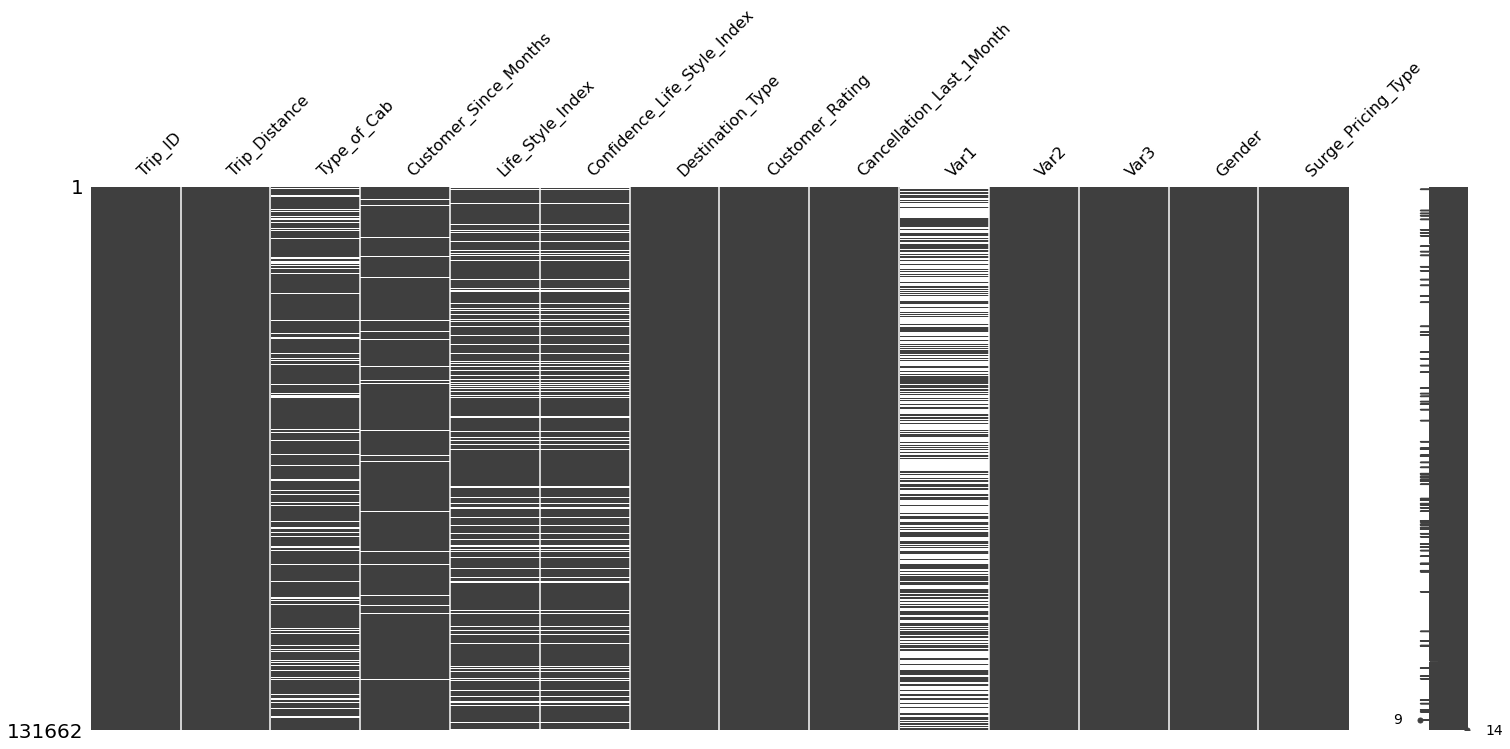

In [7]:
msno.matrix(data)

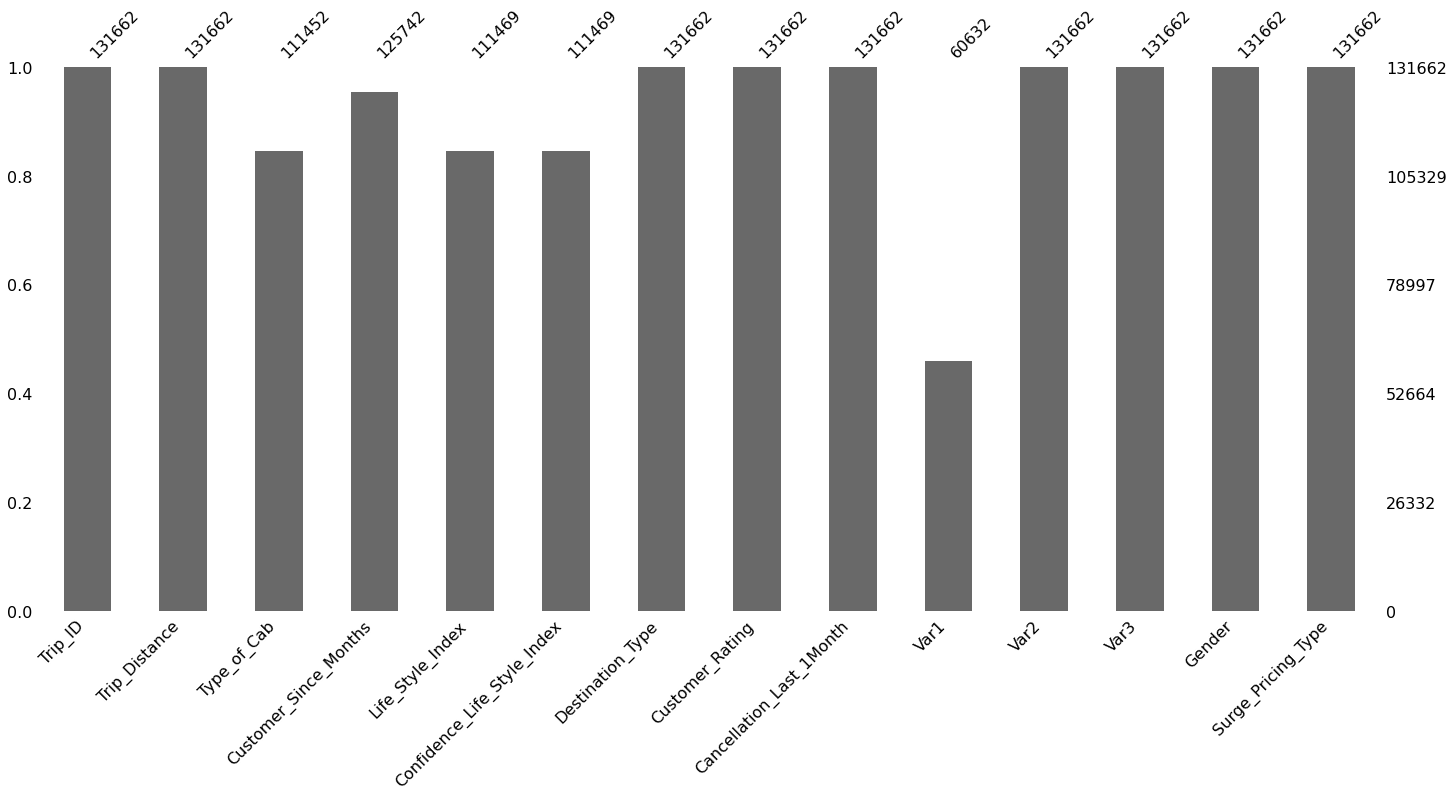

In [8]:
msno.bar(data)

Columns to drop:

1. Trip Id- this is unique for every observation and this doesn't effect our analysis much.

2. Var 1- more than 40% of the column values are null with very low correlation with the surge price

Looking at the correlation heat map to understand the correlation between variables wrt surge pricing.

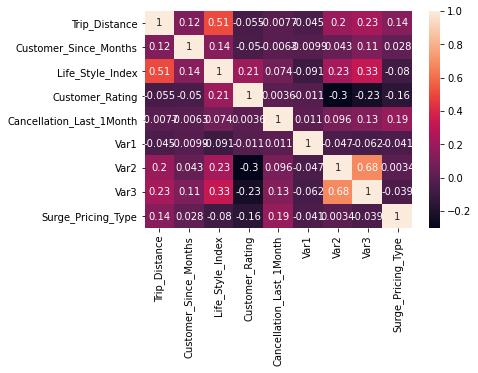

In [9]:
import seaborn as sns

sns.heatmap(data.corr(),annot= True)

#Data Cleaning.

In [10]:
#Dropping not needed columns

data.drop(columns=['Trip_ID','Var1'],inplace= True)

In [11]:
data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,124.000000,206.000000,3.000000


Making nan values in  Life style index to 0 to prevent any loss of information.

In [12]:
data['Life_Style_Index']=data['Life_Style_Index'].fillna(data['Life_Style_Index'].median())

In [13]:
#I'll try to understand the lifestyle index better
data['Life_Style_Index'].describe()

count    131662.000000
mean          2.801448
std           0.207765
min           1.596380
25%           2.687952
50%           2.798050
75%           2.912815
max           4.875110
Name: Life_Style_Index, dtype: float64

In [14]:
#To put them as categorical values to understand which lifestyle has most effect in price surge

def lifestyle(x):
  if x>2.9:
     return 'high'
  elif x<=2.9 and x>2.6:
    return 'medium'
  else:
    return 'low'


In [15]:
data['Life_Style_Category']= data['Life_Style_Index'].apply(lifestyle)

Text(0.5, 1.0, ' Category the Life Style lies in')

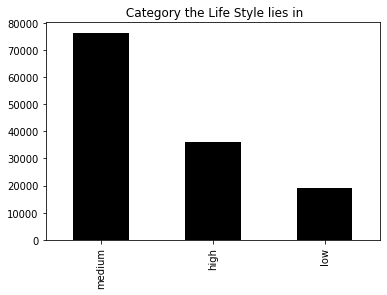

In [16]:
data['Life_Style_Category'].value_counts().plot(kind='bar',color= 'black')

plt.title(' Category the Life Style lies in')

Most of the life style of the customers lie in the medium kind of lifestyle.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_Distance                131662 non-null  float64
 1   Type_of_Cab                  111452 non-null  object 
 2   Customer_Since_Months        125742 non-null  float64
 3   Life_Style_Index             131662 non-null  float64
 4   Confidence_Life_Style_Index  111469 non-null  object 
 5   Destination_Type             131662 non-null  object 
 6   Customer_Rating              131662 non-null  float64
 7   Cancellation_Last_1Month     131662 non-null  int64  
 8   Var2                         131662 non-null  int64  
 9   Var3                         131662 non-null  int64  
 10  Gender                       131662 non-null  object 
 11  Surge_Pricing_Type           131662 non-null  int64  
 12  Life_Style_Category          131662 non-null  object 
dtyp

In [18]:
data['Customer_Since_Months']= data['Customer_Since_Months'].fillna(data['Customer_Since_Months'].median())

Text(0.5, 1.0, 'Customer Since Months')

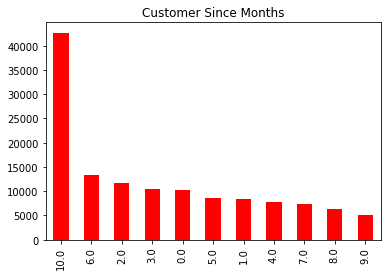

In [19]:
data['Customer_Since_Months'].value_counts().plot(kind='bar',color='red')

plt.title('Customer Since Months')

Most of the customers have been customers for 10 months or more.

Most customers have had a positive experience to have been customer for such a long time.

Text(0.5, 1.0, 'Cancellation in Last 1 Month')

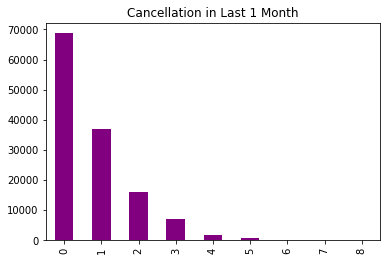

In [20]:
data['Cancellation_Last_1Month'].value_counts().plot(kind='bar',color='purple')

plt.title('Cancellation in Last 1 Month')

Most customers have made 0 or 1 cancellations mostly in the last month.

Let us understand the trip distance distribution:

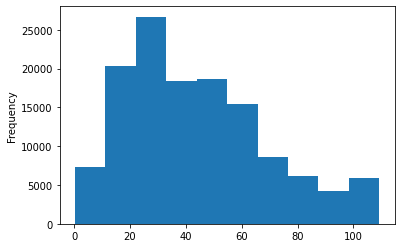

In [21]:
data['Trip_Distance'].plot(kind='hist')

Type of cab with surge price:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


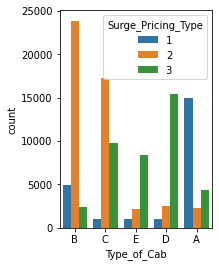

In [23]:
plt.subplot(1,2,2)
sns.countplot(data['Type_of_Cab'],hue=data['Surge_Pricing_Type'])

Looking for nan values in the type of cab column.

In [24]:
data['Type_of_Cab'].isnull().sum()

20210

In [25]:
data['Type_of_Cab'].value_counts()

B    31136
C    28122
A    21569
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

In [26]:
data['Type_of_Cab']= data['Type_of_Cab'].fillna('F')

In [27]:
data['Type_of_Cab'].value_counts()

B    31136
C    28122
A    21569
F    20210
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

In [28]:
labels = data['Type_of_Cab'].unique()

In [29]:
labels

array(['B', 'F', 'C', 'E', 'D', 'A'], dtype=object)

([<matplotlib.patches.Wedge at 0x7fc1e45766d0>,
 [Text(0.8101331604206705, 0.7440996320297547, 'B'),
  Text(-0.6084266612374032, 0.9164152977201475, 'F'),
  Text(-1.0778582045468763, -0.21959437809512375, 'C'),
  Text(-0.40077423465709566, -1.0243925091658077, 'E'),
  Text(0.5865887758474608, -0.9305447909959936, 'D'),
  Text(1.0578877170483458, -0.3014524475240489, 'A')],
 [Text(0.44189081477491116, 0.4058725265616843, '23.6%'),
  Text(-0.3318690879476744, 0.49986288966553494, '21.4%'),
  Text(-0.5879226570255689, -0.11977875168824931, '16.4%'),
  Text(-0.21860412799477943, -0.5587595504540769, '15.3%'),
  Text(0.319957514098615, -0.5075698859978147, '14.4%'),
  Text(0.5770296638445521, -0.1644286077403903, '8.8%')])

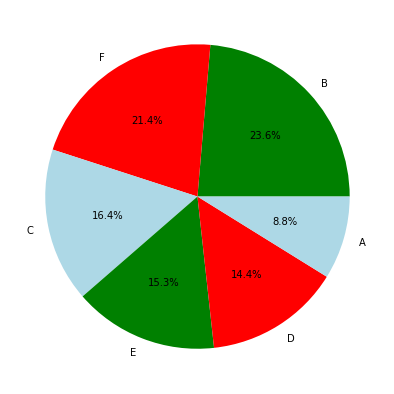

In [30]:
# Data to plot (#Final code for pie chart)
labels = data['Type_of_Cab'].unique()
sizes = data['Type_of_Cab'].value_counts()
colors = ['green', 'red', 'lightblue']

# Plot
fig = plt.figure(figsize =(10, 7))
plt.pie(sizes,labels=labels, colors=colors,autopct='%1.1f%%')


If we understand this pie chart-

1. The most popular types of cabs are B,C and E

2. Around 20% of the Customers have not entered the cab type, but due to loss of information we cannot risk removing these observations either.

#Coverting categorical columns to numerical values

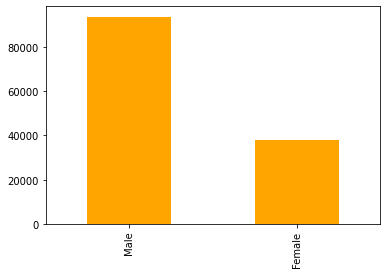

In [31]:
data['Gender'].value_counts().plot(kind='bar',color= 'orange')

In [32]:
#converting gender to 0 and 1

data['Gender']=data['Gender'].map({'Female':0, 'Male':1})

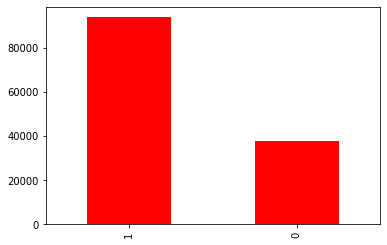

In [33]:
data['Gender'].value_counts().plot(kind= 'bar', color= 'red')

In [34]:
#One hot encoding on all the categorical columns

# One hot encoding
data= pd.get_dummies(data, columns=["Type_of_Cab", "Confidence_Life_Style_Index","Destination_Type"], prefix=["cab_type", "conf_index","destination_type"],drop_first=True)

I am not using label encoding on these categorical columns because I want my model to be robust and be able to deal with data even in the future
and I do not want to assume proportions for the future.

In [35]:
data.head(5)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Gender,Surge_Pricing_Type,Life_Style_Category,cab_type_B,cab_type_C,cab_type_D,cab_type_E,cab_type_F,conf_index_B,conf_index_C,destination_type_B,destination_type_C,destination_type_D,destination_type_E,destination_type_F,destination_type_G,destination_type_H,destination_type_I,destination_type_J,destination_type_K,destination_type_L,destination_type_M,destination_type_N
0,6.77,1.0,2.42769,3.90500,0,46,60,0,2,low,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29.47,10.0,2.78245,3.45000,0,56,78,1,2,medium,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41.58,10.0,2.79805,3.50125,2,56,77,1,2,medium,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,61.56,10.0,2.79805,3.45375,0,52,74,1,3,medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,54.95,10.0,3.03453,3.40250,4,49,102,1,2,high,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
data.drop(columns= 'Life_Style_Category',inplace= True)

In [37]:
data.head(3)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Gender,Surge_Pricing_Type,cab_type_B,cab_type_C,cab_type_D,cab_type_E,cab_type_F,conf_index_B,conf_index_C,destination_type_B,destination_type_C,destination_type_D,destination_type_E,destination_type_F,destination_type_G,destination_type_H,destination_type_I,destination_type_J,destination_type_K,destination_type_L,destination_type_M,destination_type_N
0,6.77,1.0,2.42769,3.90500,0,46,60,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29.47,10.0,2.78245,3.45000,0,56,78,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41.58,10.0,2.79805,3.50125,2,56,77,1,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Trip_Distance             131662 non-null  float64
 1   Customer_Since_Months     131662 non-null  float64
 2   Life_Style_Index          131662 non-null  float64
 3   Customer_Rating           131662 non-null  float64
 4   Cancellation_Last_1Month  131662 non-null  int64  
 5   Var2                      131662 non-null  int64  
 6   Var3                      131662 non-null  int64  
 7   Gender                    131662 non-null  int64  
 8   Surge_Pricing_Type        131662 non-null  int64  
 9   cab_type_B                131662 non-null  uint8  
 10  cab_type_C                131662 non-null  uint8  
 11  cab_type_D                131662 non-null  uint8  
 12  cab_type_E                131662 non-null  uint8  
 13  cab_type_F                131662 non-null  u

Understanding the importance of each variable on the surge price dependent variable by SHAP values:

#Implementing RandomForrestClassifier:

Implementing train-test split:

In [39]:
X=data[[col for col in data.columns if col not in ['Surge_Pricing_Type']]]
Y=data['Surge_Pricing_Type']

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [41]:
# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=42)

Looking for most important features:

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
Extra=ExtraTreesClassifier()

Extra.fit(X,Y)
imp_features=pd.Series(Extra.feature_importances_,index=X.columns).sort_values(ascending=False)
imp_features

Trip_Distance               0.120193
Customer_Rating             0.115215
Life_Style_Index            0.105810
Var3                        0.103836
Var2                        0.094252
cab_type_B                  0.091469
cab_type_D                  0.073376
Customer_Since_Months       0.069072
cab_type_C                  0.056133
Cancellation_Last_1Month    0.040713
cab_type_E                  0.032594
cab_type_F                  0.024504
Gender                      0.016955
conf_index_B                0.012004
destination_type_B          0.009534
conf_index_C                0.007879
destination_type_C          0.005576
destination_type_D          0.004649
destination_type_E          0.002903
destination_type_F          0.002584
destination_type_H          0.002044
destination_type_G          0.002030
destination_type_L          0.001587
destination_type_I          0.001571
destination_type_K          0.001528
destination_type_J          0.001371
destination_type_M          0.000342
d

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

Standardizing is not needed while using Random Classifier for tree based classifier:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Metric scores:

In [ ]:
from sklearn.metrics import accuracy_score,recall_score,plot_confusion_matrix,roc_auc_score

In [ ]:
# make predictions for test data
y_pred = classifier.predict(X_test)

In [ ]:
# Training accuracy
accuracy_score(y_train, classifier.predict(X_train))*100

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Average:This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

We cannot use binary for multiclass label problem.


In [ ]:
print("Precision:", precision_score(y_test,y_pred,average='macro')*100)

In [ ]:
print("Recall:",recall_score(y_test,y_pred,average='macro')*100)

Plotting the confusion matrix:

In [ ]:
#For train
plot_confusion_matrix(classifier,X_train,y_train)

In [ ]:
#For test
plot_confusion_matrix(classifier,X_test,y_test)

#Using hyperparamter tuning by Randomized Search Cv:

In [ ]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

#Average parameters
#avg= [None,'micro','macro','samples','weighted']

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
              

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

In [ ]:
#Random search
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=2,cv=5)

In [ ]:
rf_random.fit(X_train,y_train)


In [ ]:
#The best esitmators
rf_random.best_estimator_

In [ ]:
#Building optimal model on the best estimators
rf_optimal_model = rf_random.best_estimator_

In [ ]:
# make predictions for test data
y_pred_r = rf_optimal_model.predict(X_test)

In [ ]:
# Training accuracy
accuracy_score(y_train, rf_optimal_model.predict(X_train))*100

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_r)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
print("Precision:", precision_score(y_test,y_pred_r,average='macro')*100)

In [ ]:
print("Recall:",recall_score(y_test,y_pred_r,average='macro')*100)

In [ ]:
#For train
plot_confusion_matrix(rf_optimal_model,X_train,y_train)

In [ ]:
#For train
plot_confusion_matrix(rf_optimal_model,X_test,y_test)